In [12]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("/glade/work/schreck/repos/HOLO/clean/holodec-ml")
from holodecml.data import *
from holodecml.losses import *
from holodecml.models import *
from holodecml.metrics import *
from holodecml.transforms import *
from holodecml.propagation import *

import os
import glob
import tqdm
import time
import yaml
import scipy
import torch
import shutil
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import matplotlib

import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

from colour import Color
import multiprocessing as mp
from functools import partial

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from scipy.spatial import distance_matrix

In [13]:
path = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/manopt"
config = f'{path}/model.yml'

with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [3]:
test_synthetic_data = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_test.nc'
test_real_data = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/real_holograms_CSET_RF07_20150719_200000-210000.nc'

dataset = test_synthetic_data

if dataset == test_real_data:
    set_flag = "real_10_20"
else:
    set_flag = "synthetic"

In [4]:
n_nodes = conf["inference"]["n_nodes"]
n_gpus = conf["inference"]["gpus_per_node"]
threads_per_gpu = conf["inference"]["threads_per_gpu"]
workers = int(n_nodes * n_gpus * threads_per_gpu)

save_arrays = conf["inference"]["save_arrays"]
plot = conf["inference"]["plot"]

n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
data_path = conf["data"]["data_path"]
raw_path = conf["data"]["raw_data"]
transform_mode = "None" if "transform_mode" not in conf["data"] else conf["data"]["transform_mode"]

model_loc = conf["save_loc"]
model_name = conf["model"]["name"]
color_dim = conf["model"]["in_channels"]

batch_size = conf["inference"]["batch_size"]
save_arrays = conf["inference"]["save_arrays"]
save_prob = conf["inference"]["save_probs"]
inference_mode = conf["inference"]["mode"]
probability_threshold = conf["inference"]["probability_threshold"]

plot = conf["inference"]["plot"]
verbose = conf["inference"]["verbose"]
data_set = conf["inference"]["data_set"]["path"]
data_set_name = conf["inference"]["data_set"]["name"]

prop_data_loc = os.path.join(model_loc, f"{data_set_name}/propagated")
roc_data_loc = os.path.join(model_loc, f"{data_set_name}/roc")
image_data_loc = os.path.join(model_loc, f"{data_set_name}/images")

In [121]:
pred_coordinates = defaultdict(list)
true_coordinates = defaultdict(list)

for h_idx in [0, 2]:
    
    processed_preds = f'{model_loc}/{set_flag}/propagated/pred_{h_idx}_*'
    holo_predictions = sorted(glob.glob(processed_preds), key = lambda x: int(x.split("_")[-1].strip(".npz")))

    true_particles = 0
    pred_particles = 0
    for k, holo_file in tqdm.tqdm(enumerate(holo_predictions), total = len(holo_predictions)):
        
        zind = int(holo_file.split("_")[-1].strip(".npz"))

        # Check if there are any TRUE masks for this z-plane
        _array = load_sparse_csr(holo_file.strip(".npz").replace("pred", "true"))
        
        if _array.sum() > 0:

            arr, n = scipy.ndimage.label(_array.toarray() == 1)
            _centroid = scipy.ndimage.find_objects(arr)

            for particle in _centroid:
                xind = int(np.mean([int(x) for x in str(particle[0]).strip("slice(").strip(", None)").split(", ")]))
                yind = int(np.mean([int(x) for x in str(particle[1]).strip("slice(").strip(", None)").split(", ")]))
                true_coordinates[h_idx].append([xind,yind,zind])
                true_particles += 1

        # Check if there are any PREDICTED masks for this z-plane
        _array = load_sparse_csr(holo_file.strip(".npz"))

        if _array.sum() > 0:

            arr, n = scipy.ndimage.label(_array.toarray() == 1)
            _centroid = scipy.ndimage.find_objects(arr)

            for particle in _centroid:
                xind = int(np.mean([int(x) for x in str(particle[0]).strip("slice(").strip(", None)").split(", ")]))
                yind = int(np.mean([int(x) for x in str(particle[1]).strip("slice(").strip(", None)").split(", ")]))
                pred_coordinates[h_idx].append([xind,yind,zind])
                pred_particles += 1
            
    print(h_idx, true_particles, pred_particles)

  0%|          | 1/1000 [00:00<00:05, 196.74it/s]


In [6]:
# scale_x = 1.0 # 4872 2.96e-06 4286
# scale_y = 1.0 # 3248, #2.96e-06
# scale_z = 0.01 # 14072 - 157928 #143.856e-06

class Threshold:
    
    def __init_(self):
        self.n = None
    
    def load_dist_matrix(self, h_idx, coordinates):
        
        vol = np.array(coordinates[h_idx], dtype = float)
        
#         vol[:,0] *= scale_x
#         vol[:,1] *= scale_y
#         vol[:,2] *= scale_z

        # just min-max x,y,z to put onto same scale
        vol[:, 0] /= 4872
        vol[:, 1] /= 3248
        vol[:, 2] -= 14072
        vol[:, 2] /= 157928

        self.dist_matrix = distance_matrix(vol, vol)
        self.n = self.dist_matrix.shape[0]
    
    def search(self, threshold):
        results = {}
        for label in range(self.n):
            # Find experiments at or below the threshold
            members = np.where(self.dist_matrix[label] <= threshold)[0]
            results[label] = [x for x in members if x != label]
        results = sorted([
            [len(x), i, x] for (i, x) in results.items()
        ])
        return results #sorted(results, reverse=True)
    
    def Cluster(self, threshold):
        # Use Leader clustering
        true_singletons = []
        false_singletons = []
        clusters = []
        seen = set()
        for (size, experiment, members) in self.search(threshold):
            if experiment in seen:
                # Can't use a centroid which is already assigned
                continue
            seen.add(experiment)
            # Figure out which ones haven't yet been assigned
            unassigned = set(members) - seen
            if not unassigned:
                false_singletons.append(experiment)
                continue
            # this is a new cluster
            clusters.append((experiment, unassigned))
            seen.update(unassigned)
            
        seen = []
        for a,b in clusters:
            seen.append(a)
            for c in b:
                if c not in seen:
                    seen.append(c)
        
        not_clustered = set(range(self.n)) - set(seen)
        return sorted(clusters, key = lambda x: -len(x[1])), list(not_clustered)

### As an example, cluster on just one hologram

In [53]:
h_idx = 2

In [54]:
t = Threshold()

In [55]:
t.load_dist_matrix(h_idx, pred_coordinates)

In [56]:
thresholds = np.logspace(-3.2, -2, 5000)
y1, y2 = [], []

for ts in tqdm.tqdm(thresholds):
    clusters, unassigned = t.Cluster(ts)
    y1.append(len(clusters))
    y2.append(len(unassigned))
    #print(ts, len(clusters), len(unassigned))
y3 = [p1+p2 for p1, p2 in zip(y1, y2)]

100%|██████████| 5000/5000 [03:39<00:00, 22.73it/s]


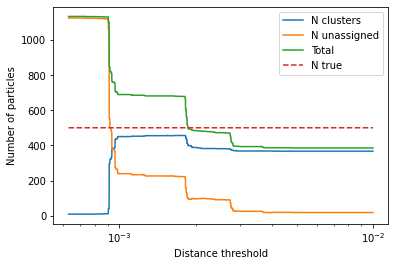

In [57]:
plt.plot(thresholds, y1)
plt.plot(thresholds, y2)
plt.plot(thresholds, y3)
plt.plot(thresholds, [500 for p1 in y1], ls = '--')
plt.legend(["N clusters", "N unassigned", "Total", "N true"])
plt.ylabel("Number of particles")
plt.xlabel("Distance threshold") 

plt.xscale("log")

In [58]:
# Find the largest number of clustered particles less the true value
total_true_particles = len(true_coordinates[h_idx])

min(y3, key=lambda x: abs(x - total_true_particles))

486

In [59]:
which_id = np.where(np.array(y3) == min(y3, key=lambda x: abs(x - total_true_particles)))

In [60]:
thresholds[which_id]

array([0.00193668, 0.00193775, 0.00193882, 0.00193989, 0.00194096,
       0.00194204, 0.00194311, 0.00194419, 0.00194526, 0.00194634,
       0.00194741, 0.00194849, 0.00194957, 0.00195064, 0.00195172,
       0.0019528 , 0.00195388, 0.00195496])

In [61]:
clusters, unassigned = t.Cluster(thresholds[which_id][0])

In [90]:
clusters, unassigned = t.Cluster(0.0024)

In [91]:
len(clusters), len(unassigned)

(382, 90)

In [92]:
centroid, members = clusters[0]

In [93]:
centroid

875

In [94]:
members

{876, 877, 878, 879, 880}

In [95]:
pred_coordinates[0][centroid]

[2635, 1292, 104935]

In [96]:
[pred_coordinates[0][xx] for xx in members]

[[2648, 3077, 104935],
 [1097, 1881, 105079],
 [2635, 1293, 105079],
 [2650, 3077, 105079],
 [4528, 499, 105079]]

### Align the clustered particles against the real ones using distance matrix

In [97]:
pred_r_centroids = np.array([pred_coordinates[0][centroid] for centroid, members in clusters]).astype(float)
pred_r_not_matched = np.array([pred_coordinates[0][idx] for idx in unassigned]).astype(float)
pred_r = np.concatenate([pred_r_centroids, pred_r_not_matched])

true_r = np.array(true_coordinates[0]).astype(float)

In [98]:
scale_x = 2.96e-06 
scale_y = 2.96e-06
scale_z = 143.856e-06

In [99]:
import math

scales = [scale_x, scale_y, scale_z]

# Define a distance function between two points
def distance(x, y):
    return math.sqrt(sum([(scales[i] * x[i] - scales[i] * y[i])**2 for i,_ in enumerate(x)]))

# For a point x, loop over candidates and find the closest point y
# Use tuples so we can refer to the y value with shortest distance by 
# sorting over the latter
def get_closest(x, B):
    distances = ((y, distance(x,y)) for y in B)
    closest = sorted(distances, key=lambda x: x[1])[0][0]
    return closest

# Loop over x points and find each of their closest points
# Output results as a list of (x,y) tuples
def match_up(A, B):
    pairs = [list((x, get_closest(x, B))) for x in A]
    return pairs

In [100]:
matched = match_up(pred_r, true_r)

In [101]:
len([set(list(x[0])) for x in matched])

472

In [102]:
# how many of the true particles were matched uniquely:
len(set([str(list(x[1])) for x in matched]))

323

In [103]:
total_error = []
for a1, b1 in matched:
    error = distance(a1, b1)
    total_error.append(np.mean(np.abs(error)))

In [104]:
np.mean(total_error)

0.00985850864860816

### Compute without duplication

In [105]:
# compute the distance matrix b/t the two datasets --> pandas df
result_dict = defaultdict(list)
for k1, x in tqdm.tqdm(enumerate(pred_r)):
    for k2, y in enumerate(true_r):        
        error = distance(x, y) 
        result_dict["pred_id"].append(k1)
        result_dict["true_id"].append(k2)
        result_dict["error"].append(np.mean(np.abs(error)))   
        
df = pd.DataFrame(result_dict)

472it [00:03, 131.79it/s]


In [153]:
pred_seen = []
true_seen = []
error = []

while True:
    
    c1 = df["true_id"].isin(true_seen)
    c2 = df["pred_id"].isin(pred_seen)
    c = c1 | c2
    
    if c.sum() == df.shape[0]:
        break
    
    smallest_error = df[~c]["error"] == min(df[~c]["error"])
    true_id = list(df[~c][smallest_error]["true_id"])[0]
    pred_id = list(df[~c][smallest_error]["pred_id"])[0]
    pred_seen.append(pred_id)
    true_seen.append(true_id)
    error.append(list(df[~c][smallest_error]["error"])[0])

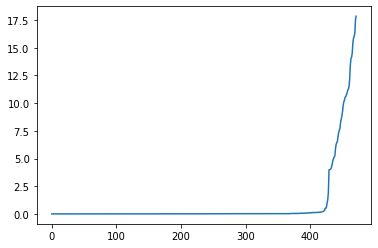

In [154]:
plt.plot(range(len(error)), error)

In [155]:
np.mean([x for x in error])

0.8973932025308197